In [1]:
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torchvision
from torchvision import transforms

# 211016
Russula 92번 이미지 깨져서 삭제  
깨진 이미지 있어도 진행하는 방법이 있어서 해보았으나 처리가 안됨 

In [2]:
def imshow(img):
    img = img /2 + 0.5 # unnormalize
    np_img = img.numpy()
    # plt.imshow(np_img)
    plt.imshow(np.transpose(np_img, (1,2,0)))
    
    print(np_img.shape)
    print((np.transpose(np_img,(1,2,0))).shape)

In [3]:
import os

os.listdir('./Mushrooms_images')

['Agaricus',
 'Amanita',
 'Boletus',
 'Cortinarius',
 'Entoloma',
 'Hygrocybe',
 'Lactarius',
 'Russula',
 'Suillus']

# 211018
train_test_split 이용 테스트 셋, 트레인 셋 분리

In [4]:
from sklearn.model_selection import train_test_split

trans = transforms.Compose([transforms.Resize((32,32)),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                           ])

imageData = torchvision.datasets.ImageFolder(root = "./Mushrooms_images",
                                           transform = trans)

#trainset, testset = train_test_split(imageData, test_size=0.2)

In [5]:
#len(trainset)

In [6]:
#len(testset)

In [7]:
# trainloader = DataLoader(trainset,
#                         batch_size = 100,
#                         shuffle = True,
#                         num_workers = 2)

# testloader = DataLoader(testset,
#                         batch_size = 100,
#                         shuffle = False,
#                         num_workers = 2)

In [8]:
classes = imageData.classes
classes

['Agaricus',
 'Amanita',
 'Boletus',
 'Cortinarius',
 'Entoloma',
 'Hygrocybe',
 'Lactarius',
 'Russula',
 'Suillus']

In [9]:
# dataiter = iter(trainloader)
# images, labels = dataiter.next()
# print(labels)

In [10]:
# print(images.shape)
# imshow(torchvision.utils.make_grid(images, nrow=4)) # imshow 함수 호출
# print(images.shape)
# print((torchvision.utils.make_grid(images)).shape)
#print("".join("%5s "%classes[labels[j]] for j in range(50)))

In [11]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # kernel=5, paddig=0. stride=1. 32-5+1=28
        self.pool = nn.MaxPool2d(2, 2)  # 14
        self.conv2 = nn.Conv2d(6, 16, 5) # kernel=5, paddig=0. stride=1. 14-5+1=10 => max pooling 후 5X5
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        # 84를 60으로 변경 테스트
        self.fc2 = nn.Linear(120, 20)
        self.fc3 = nn.Linear(20, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 211017
Adam으로 변경, momentum 0.9와 0.999로 변화

In [12]:
import torch.optim as optim

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))

# 211017 
running_loss 계산 식 수정

# 211018
KFold 추가

In [13]:
# for epoch in range(10):   # 데이터셋을 수차례 반복합니다.

#     running_loss = 0.0

#     for i, data in enumerate(trainloader, 0):
#         # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
#         inputs, labels = data
#         # 변화도(Gradient) 매개변수를 0으로 만들고
#         optimizer.zero_grad()

#         # 순전파 + 역전파 + 최적화를 한 후
#         outputs = net(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         # 통계를 출력합니다.
#         running_loss += loss.item()
#         if i % 50 == 49:    
#             print('[%d, %5d] loss: %.3f' %
#                       (epoch + 1, i + 1, running_loss / 50))
#             running_loss = 0.0

# print('Finished Training')

In [28]:
from sklearn.model_selection import KFold


# 폴드 세트를 5개인 KFold객체를 생성
kfold = KFold(n_splits=5)
       
# KFold 교차 검증 수행. 
    
for idx, (train_index, test_index) in enumerate(kfold.split(imageData)):
    
    trainset = torch.utils.data.Subset(imageData, train_index)
    testset = torch.utils.data.Subset(imageData, test_index)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=50, shuffle=True, num_workers=2)
    testloader = torch.utils.data.DataLoader(testset, batch_size=50, shuffle=True, num_workers=2)


    for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

        running_loss = 0.0

        for i, data in enumerate(trainloader, 0):
            # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
            inputs, labels = data
            # 변화도(Gradient) 매개변수를 0으로 만들고
            optimizer.zero_grad()

            # 순전파 + 역전파 + 최적화를 한 후
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # 통계를 출력합니다.
            running_loss += loss.item()
            if i % 100 == 99:    
                print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0

    print('Finished Training')

    dataiter = iter(testloader)
    correct = 0
    for j in range(20):
        images, labels = dataiter.next()
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)

        for k in range(50):  
            if labels[k] == predicted[k]:
                correct += 1
    
    print('정확도 : ', correct, '/', (j+1)*50, ',', '%.3f' % (correct/((j+1)*50) * 100), '%') 

[1,   100] loss: 0.118
[2,   100] loss: 0.046
Finished Training
정확도 :  471 / 1000 , 47.100 %
[1,   100] loss: 0.107
[2,   100] loss: 0.044
Finished Training
정확도 :  942 / 1000 , 94.200 %
[1,   100] loss: 0.072
[2,   100] loss: 0.051
Finished Training
정확도 :  914 / 1000 , 91.400 %
[1,   100] loss: 0.047
[2,   100] loss: 0.032
Finished Training
정확도 :  992 / 1000 , 99.200 %
[1,   100] loss: 0.015
[2,   100] loss: 0.006
Finished Training
정확도 :  985 / 1000 , 98.500 %


(3, 240, 274)
(240, 274, 3)


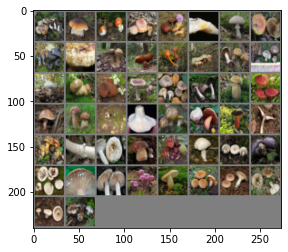

In [15]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
#images, labels = dataiter.next()
# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
#print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(50)))

In [16]:
#outputs = net(images)

In [17]:
#_, predicted = torch.max(outputs, 1)

#print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(50)))

In [23]:
dataiter = iter(trainloader)
correct = 0
for i in range(100):
    images, labels = dataiter.next()
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    #print('답: ', labels)
    #print('예측 : ', predicted)
    for j in range(50):  
        if labels[j] == predicted[j]:
            correct += 1

print(correct, '/', (i+1)*50, ',', '%.3f' % (correct/((i+1)*50) * 100), '%')            

4700 / 5000 , 94.000 %


In [25]:
dataiter = iter(testloader)
correct = 0
for i in range(20):
    images, labels = dataiter.next()
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)
    #print('답: ', labels)
    #print('예측 : ', predicted)
    for j in range(50):  
        if labels[j] == predicted[j]:
            correct += 1

print(correct, '/', (i+1)*50, ',', '%.3f' % (correct/((i+1)*50) * 100), '%')   

992 / 1000 , 99.200 %


In [27]:
# import joblib

# joblib.dump(net, 'mushroom_test.pkl')

['mushroom_test.pkl']